In [0]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
tensor([-0.6392, -0.4095, -0.5672, -1.5926, -0.6535, -0.2072, -0.5537,  0.4792,
         0.3170, -1.0047, -0.9694, -0.8127, -0.3012, -0.9415, -1.0422, -0.5840,
        -0.7709, -0.2152, -0.4871, -0.4660, -1.4640, -0.7202, -1.4319,  0.1546,
        -1.0105, -1.1641, -0.8270, -1.1429, -0.9049, -0.3479, -0.8602, -0.8306,
        -0.5092, -0.5511, -0.3435, -0.3797,  0.5508, -0.6541, -0.4612,  0.1045,
        -0.6550, -0.8266, -1.0509, -0.3942, -0.6270, -0.4757, -0.7020, -0.4685,
        -1.1735, -1.1335, -0.4323,  0.5399, -0.2932, -0.6395, -0.2480, -1.1656,
        -0.3267, -1.4873, -0.4869, -0.4733,  0.7012,  0.2167, -0.1450,  0.0967,
        -0.7136, -0.2281, -0.3226, -0.3362, -0.8113, -1.1719, -1.6868,  0.1563,
        -1.5049, -0.4013, -1.2083, -1.4170,  0.0338, -0.5737,  0.1492,  0.1184,
        -0.7775, -1.5193, -0.0720, -0.7526, -0.4552,  0.0668,  0.0907,  0.2559,
        -0.0858, -0.6279, -1.2168, -1.0731, -1.8891, -0.2

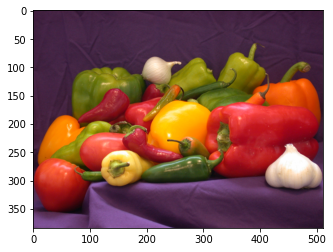

In [0]:
#####---Cornell: Deep Learning Homework 2 - CNN ---#####
import pandas as pd
import numpy as np
import math
import os
import random
import argparse
import csv
import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, AvgPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision import models
import copy

## Probblem 1: Pre-trained CNN
# Part 1: Use Pre-trained CNN
#Load data
hw2_url = "/gdrive/My Drive/Colab Notebooks/Data/"
pepper_url = hw2_url + 'peppers.jpg'

img_1 = cv2.imread(pepper_url)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
plt.imshow(img_1)

img_1 = Image.open(pepper_url)
img_1.show()

#Pre-trained model
model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=True)

    #model layers names
for name, child in model.named_children():
    print(name)

    # Record intermediate layers
inter_layers = []
def hook(module, input, inter_layer):
    inter_layers.append(inter_layer)

model.layer1[0].conv2.register_forward_hook(hook)
model.layer2[0].conv2.register_forward_hook(hook)
model.layer3[0].conv2.register_forward_hook(hook)
model.layer4[0].conv2.register_forward_hook(hook)
model.avgpool.register_forward_hook(hook)

    #input data
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img_1)
input_batch = input_tensor.unsqueeze(0)

    # move to GPU for speed if available
cuda_enabled = True

if cuda_enabled:
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    
with torch.no_grad():
    output = model(input_batch)
    
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])    

    # The output has unnormalized scores. To get probabilities, run a softmax on it.
if cuda_enabled:
    output_prob = torch.nn.functional.softmax(output[0], dim=0).detach().cpu().numpy()
else:
    output_prob = torch.nn.functional.softmax(output[0], dim=0).detach().numpy()
    
    #Top 3 prediction classes
pred_ids = np.argsort(output_prob, axis=0)
print('Predicted classes:',pred_ids[:3])
print('Probabilities:',output_prob[pred_ids[:3]])



In [0]:
## Problem 4 - Adverserial attack
# Target: class 812

# Transform & inverse transform
def preprocess_image(cv2im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    if cuda_enabled:
        im_as_ten = im_as_ten.cuda()
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    if cuda_enabled:
        im_as_var = im_as_var.cpu()
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    recreated_im = recreated_im[..., ::-1]
    return recreated_im


# Train adverserial image
img_1 = cv2.imread(pepper_url)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
initial_image = img_1
target_class = 812  # Space Shuttle



Epoch: 0 Loss: 7.629751 Confidence: 0.008540749
Epoch: 1 Loss: 7.346973 Confidence: 0.008802656
Epoch: 2 Loss: 7.209867 Confidence: 0.00861165
Epoch: 3 Loss: 7.1193805 Confidence: 0.008437395
Epoch: 4 Loss: 7.057748 Confidence: 0.0081740385
Epoch: 5 Loss: 6.9306064 Confidence: 0.0077354717
Epoch: 6 Loss: 6.9071746 Confidence: 0.008358769
Epoch: 7 Loss: 6.816959 Confidence: 0.0085557
Epoch: 8 Loss: 6.721851 Confidence: 0.0080209775
Epoch: 9 Loss: 6.7141066 Confidence: 0.007795073
Epoch: 10 Loss: 6.676283 Confidence: 0.008066299
Epoch: 11 Loss: 6.5565367 Confidence: 0.008333439
Epoch: 12 Loss: 6.5001717 Confidence: 0.007828274
Epoch: 13 Loss: 6.4737053 Confidence: 0.008088373
Epoch: 14 Loss: 6.477624 Confidence: 0.00849177
Epoch: 15 Loss: 6.4733067 Confidence: 0.008067109
Epoch: 16 Loss: 6.3431754 Confidence: 0.0074286032
Epoch: 17 Loss: 6.338695 Confidence: 0.008079523
Epoch: 18 Loss: 6.2372966 Confidence: 0.0083226245
Epoch: 19 Loss: 6.302515 Confidence: 0.008204734
Epoch: 20 Loss: 6.1

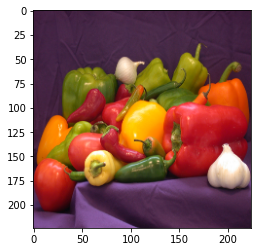

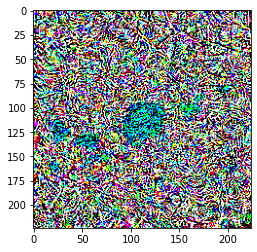

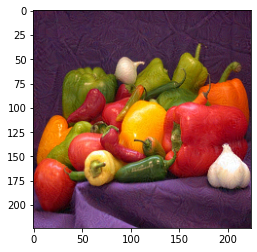

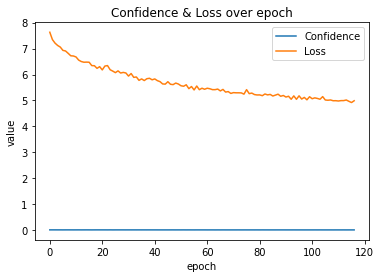

In [0]:
# Fast Gradient Sign Targeted
alpha = 0.01
epochs = 1000
confidence_history = []
loss_history = []

# I honestly dont know a better way to create a variable with specific value
# Targeting the specific class
im_label_as_var = Variable(torch.from_numpy(np.asarray([target_class])))
if cuda_enabled:
    im_label_as_var = im_label_as_var.cuda()
# Define loss functions
loss_function = nn.CrossEntropyLoss()
if cuda_enabled:
    loss_function = loss_function.cuda()
# Process image
processed_image = preprocess_image(initial_image)

# Start iteration
for i in range(epochs):
    # zero_gradients(x)
    # Zero out previous gradients
    # Can also use zero_gradients(x)
    processed_image.grad = None
    #zero_gradients(processed_image)
    # Forward pass
    out = model(processed_image)
    # Calculate CE loss
    pred_loss = loss_function(out, im_label_as_var)
    loss_history.append(pred_loss)
    # Do backward pass
    pred_loss.backward()
    # Create Noise
    # Here, processed_image.grad.data is also the same thing is the backward gradient from
    # the first layer, can use that with hooks as well
    adv_noise = alpha * torch.sign(processed_image.grad.data)
    # Add noise to processed image
    processed_image.data = processed_image.data - adv_noise

    # Confirming if the image is indeed adversarial with added noise
    # This is necessary (for some cases) because when we recreate image
    # the values become integers between 1 and 255 and sometimes the adversariality
    # is lost in the recreation process

    # Generate confirmation image
    recreated_image = recreate_image(processed_image)
    # Process confirmation image
    prep_confirmation_image = preprocess_image(recreated_image)
    # Forward pass
    confirmation_out = model(prep_confirmation_image)
    # Get prediction
    _, confirmation_prediction = confirmation_out.data.max(1)
    # Get Probability
    if cuda_enabled:
        confirmation_confidence = F.softmax(confirmation_out[0], dim=0)[confirmation_prediction].data.cpu().numpy()[0]
        confirmation_prediction = confirmation_prediction.cpu().numpy()[0]
    else:
        confirmation_confidence = F.softmax(confirmation_out[0], dim=0)[confirmation_prediction].data.numpy()[0]
        confirmation_prediction = confirmation_prediction.numpy()[0]
    
    confidence_history.append(confirmation_confidence)

    # Create the image for noise as: Original image - generated image
    noise_image = recreate_image(preprocess_image(initial_image)) - recreated_image

    # Print terminal
    if cuda_enabled:
        print('Epoch:', i, 'Loss:', pred_loss.cpu().detach().numpy(),'Confidence:',confirmation_confidence)
    else:
        print('Epoch:', i, 'Loss:', pred_loss.detach().numpy(),'Confidence:',confirmation_confidence)

    # Check if the prediction is different than the original
    if confirmation_prediction == target_class:
        print('Adversarial image was predicted as:', confirmation_prediction,
              'with confidence of:', confirmation_confidence)
        break

#Plot final image
plt.figure(0)
plt.imshow(recreate_image(preprocess_image(initial_image)))
plt.show()

plt.figure(1)
plt.imshow(noise_image)
plt.show()

plt.figure(2)
plt.imshow(recreated_image)
plt.show()

#Plot loss
plt.figure(2)
plt.plot(range(len(confidence_history)),confidence_history)
plt.plot(range(len(loss_history)),loss_history)
plt.title('Confidence & Loss over epoch')
plt.legend(['Confidence','Loss'])
plt.xlabel('epoch')
plt.ylabel('value')
plt.show()

Prediction class 463


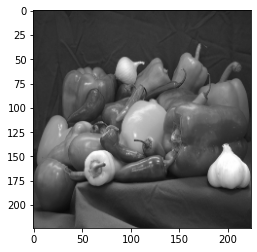

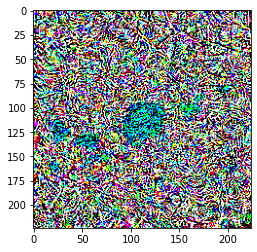

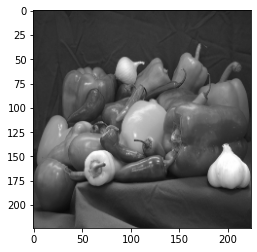

In [0]:
# Distort adverserial image
original_image = recreate_image(preprocess_image(initial_image))

#Mirror
img_distort = cv2.flip(original_image, 0)

#Crop
img_distort = original_image[:200,:200]

#Rotate 30 degree
import imutils
img_distort = imutils.rotate(original_image,30)

#Grayscale
img_distort = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
img_distort= np.stack((img_distort,)*3, axis=-1)


# Process image
processed_image = preprocess_image(img_distort)
# model
out = model(processed_image)
# Generate confirmation image
recreated_image = recreate_image(processed_image)
# Process confirmation image
prep_confirmation_image = preprocess_image(recreated_image)
# Forward pass
confirmation_out = model(prep_confirmation_image)
# Get prediction
_, confirmation_prediction = confirmation_out.data.max(1)

if cuda_enabled:
    confirmation_confidence = F.softmax(confirmation_out[0], dim=0)[confirmation_prediction].data.cpu().numpy()[0]
    confirmation_prediction = confirmation_prediction.cpu().numpy()[0]
else:
    confirmation_confidence = F.softmax(confirmation_out[0], dim=0)[confirmation_prediction].data.numpy()[0]
    confirmation_prediction = confirmation_prediction.numpy()[0]
print('Prediction class', confirmation_prediction)

#Plot final image
plt.figure(0)
plt.imshow(img_distort)
plt.show()

plt.figure(1)
plt.imshow(noise_image)
plt.show()

plt.figure(2)
plt.imshow(recreated_image)
plt.show()